In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division, print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.pyplot import GridSpec
import seaborn as sns
import numpy as np
import pandas as pd
import os, sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
sns.set_context("poster", font_scale=1.3)

import missingno as msno
import pandas_profiling

from sklearn.datasets import make_blobs
import time

In [2]:
players = pd.read_csv('players.csv.gz', compression = 'gzip', encoding = 'UTF8')

# Now onto to some EDA

In [3]:
players.shape

(2053, 8)

## Players

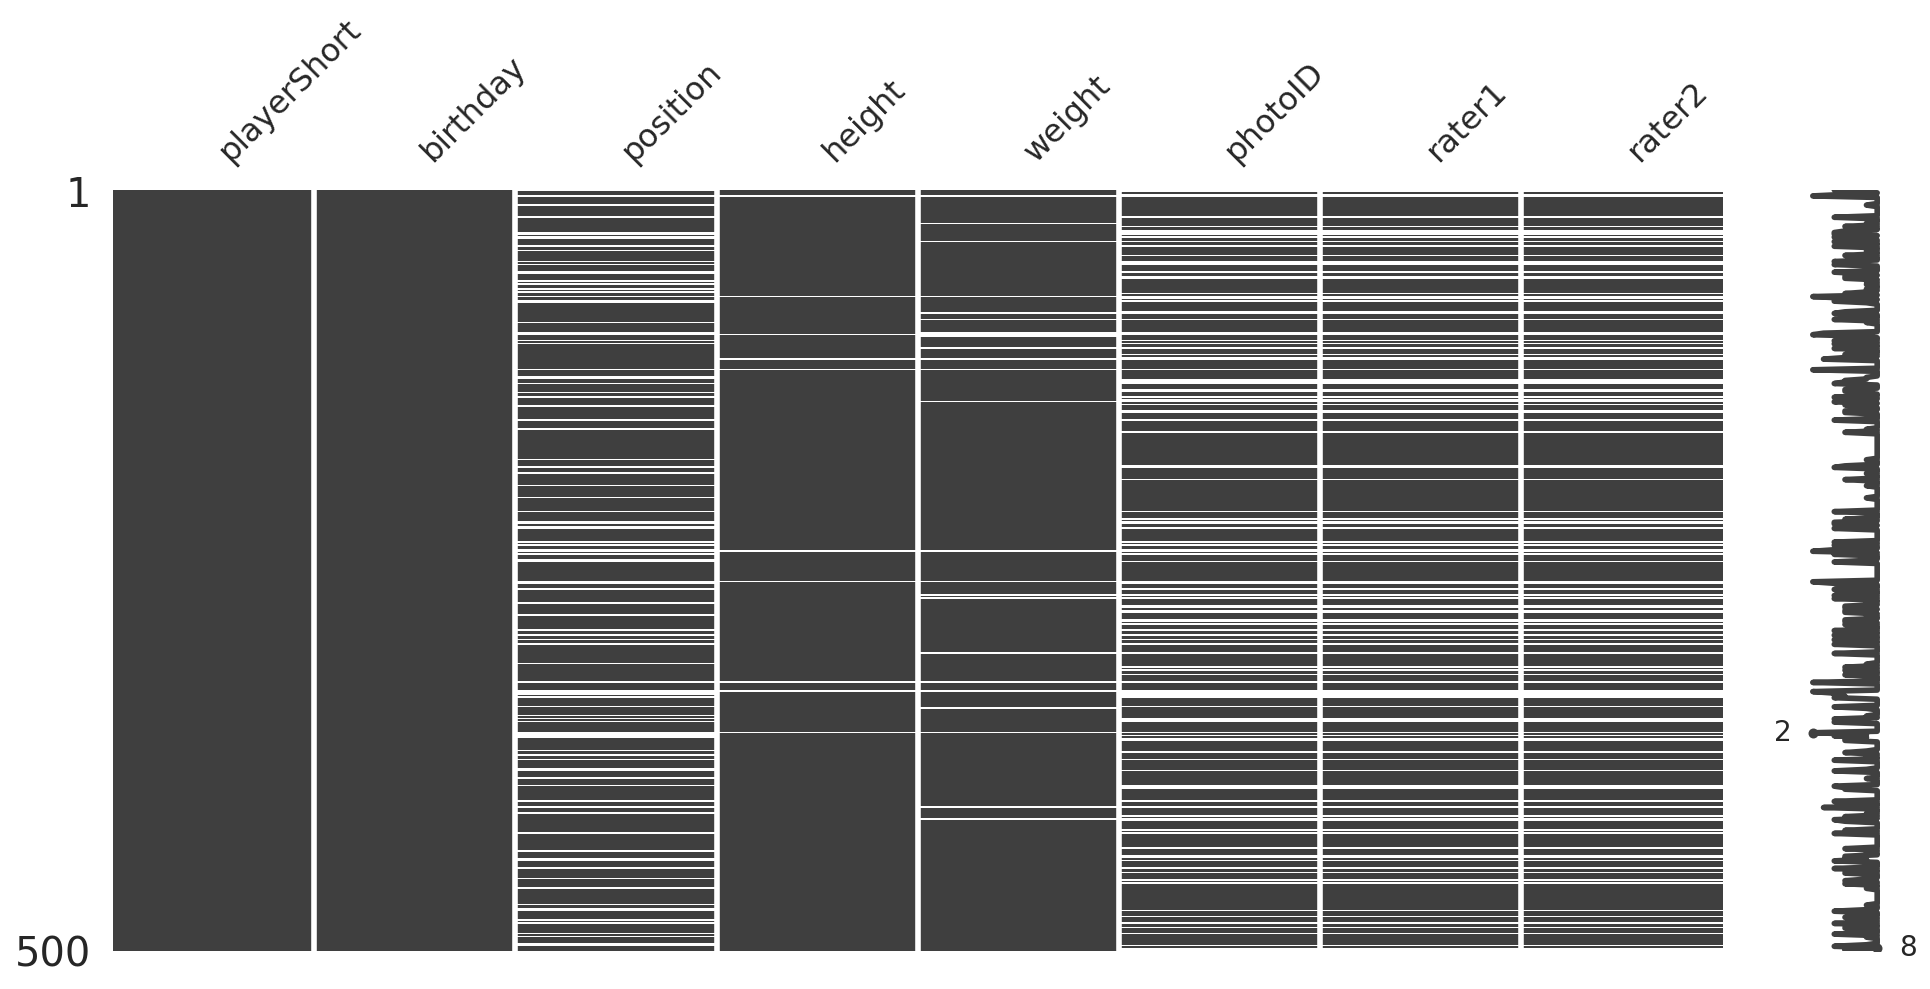

In [4]:
msno.matrix(players.sample(500), figsize = (16, 7))

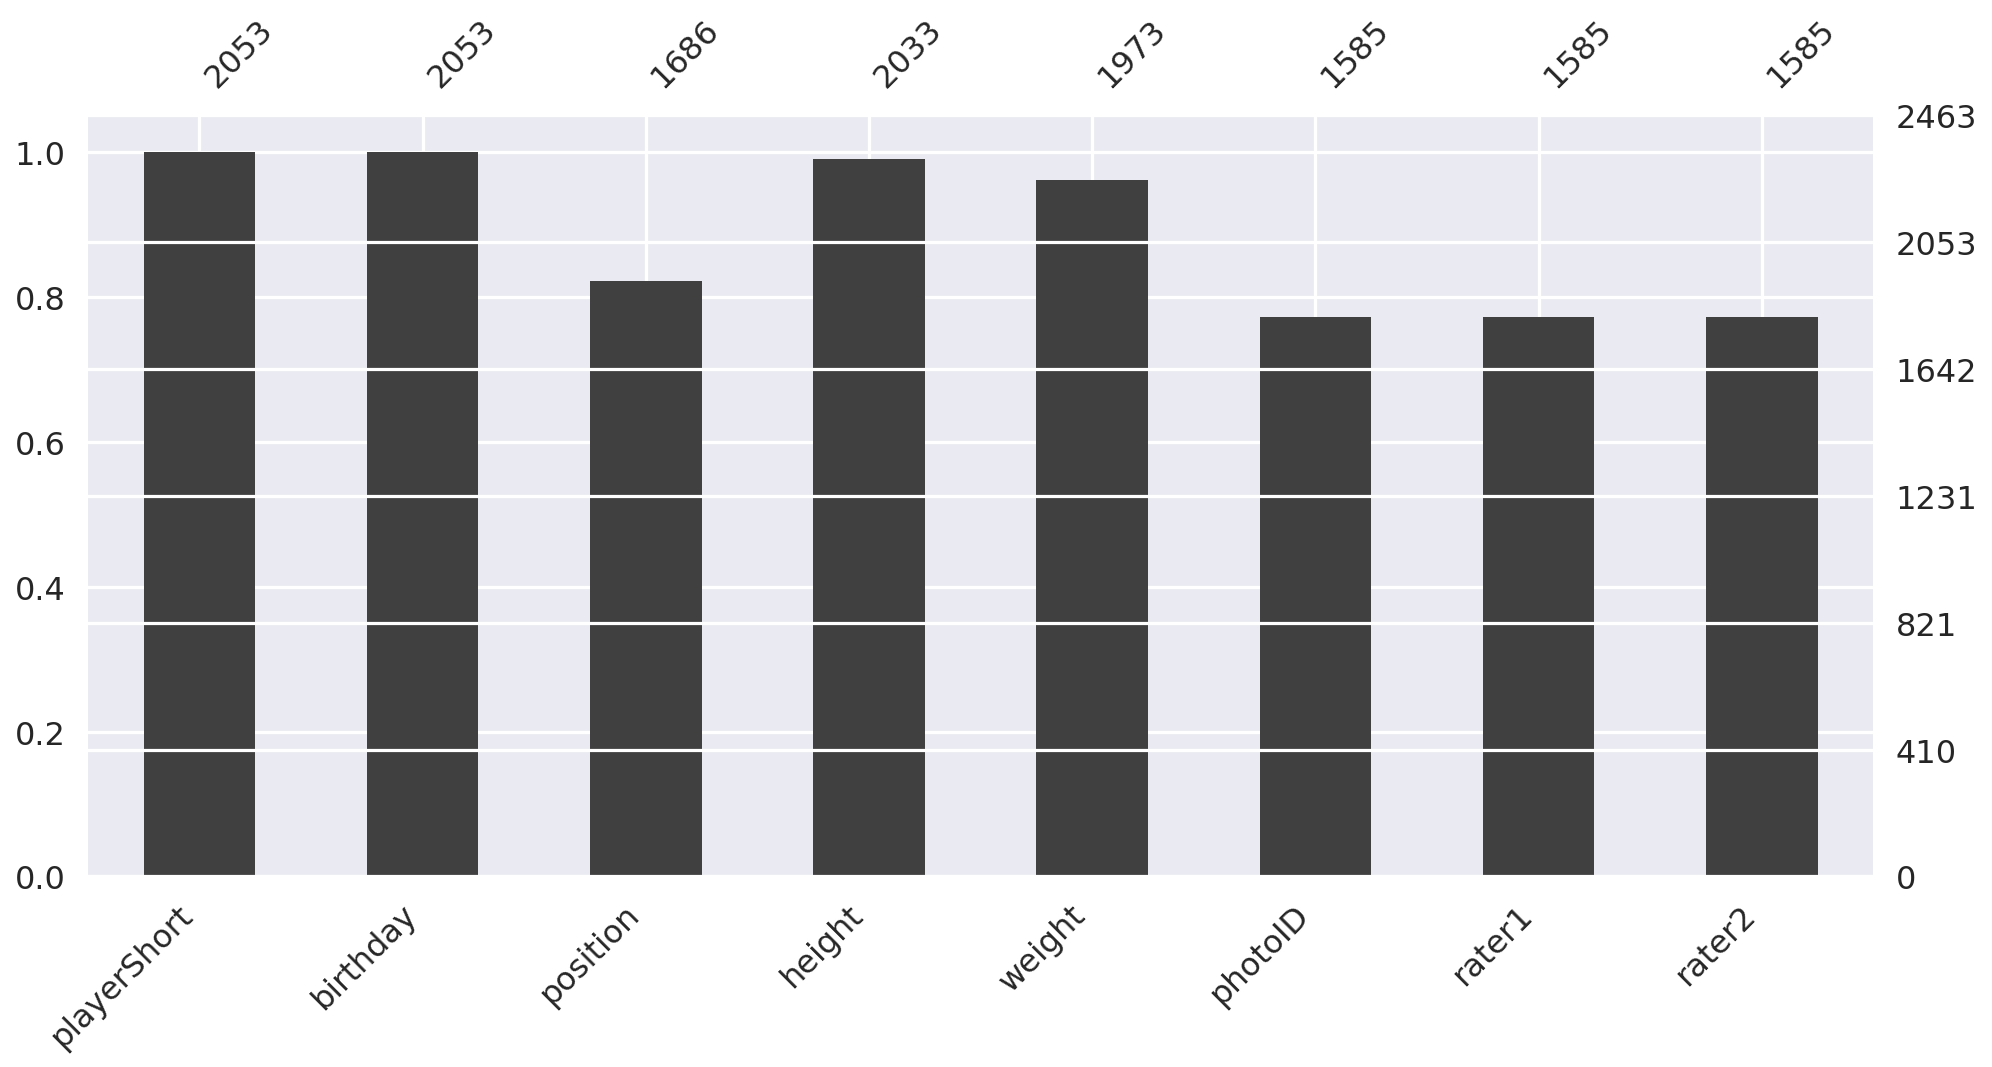

In [5]:
msno.bar(players, figsize = (16, 7))

### A lot of missing values in rater 1 and rater 2. Also in photoID. Since photoID is useless, we can drop it

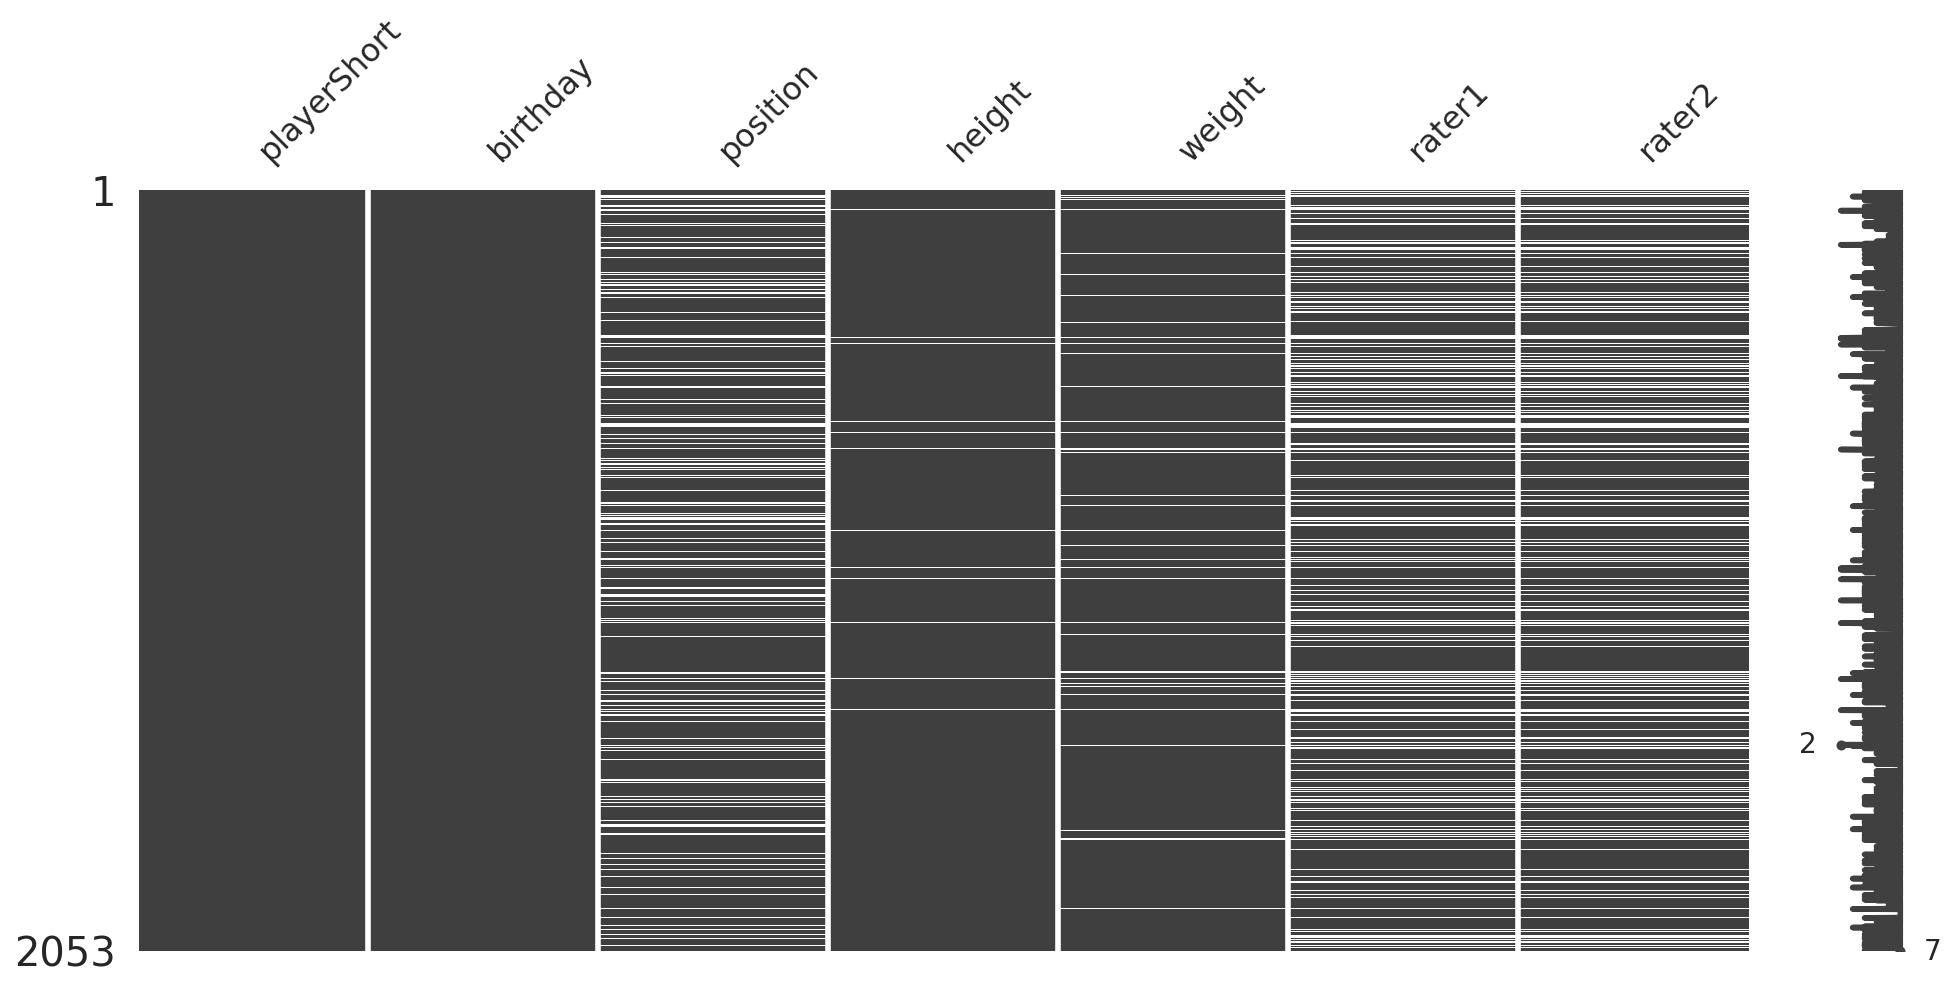

In [6]:
players.drop(columns = ['photoID'], axis = 1, inplace = True)

msno.matrix(players, figsize = (16, 7))

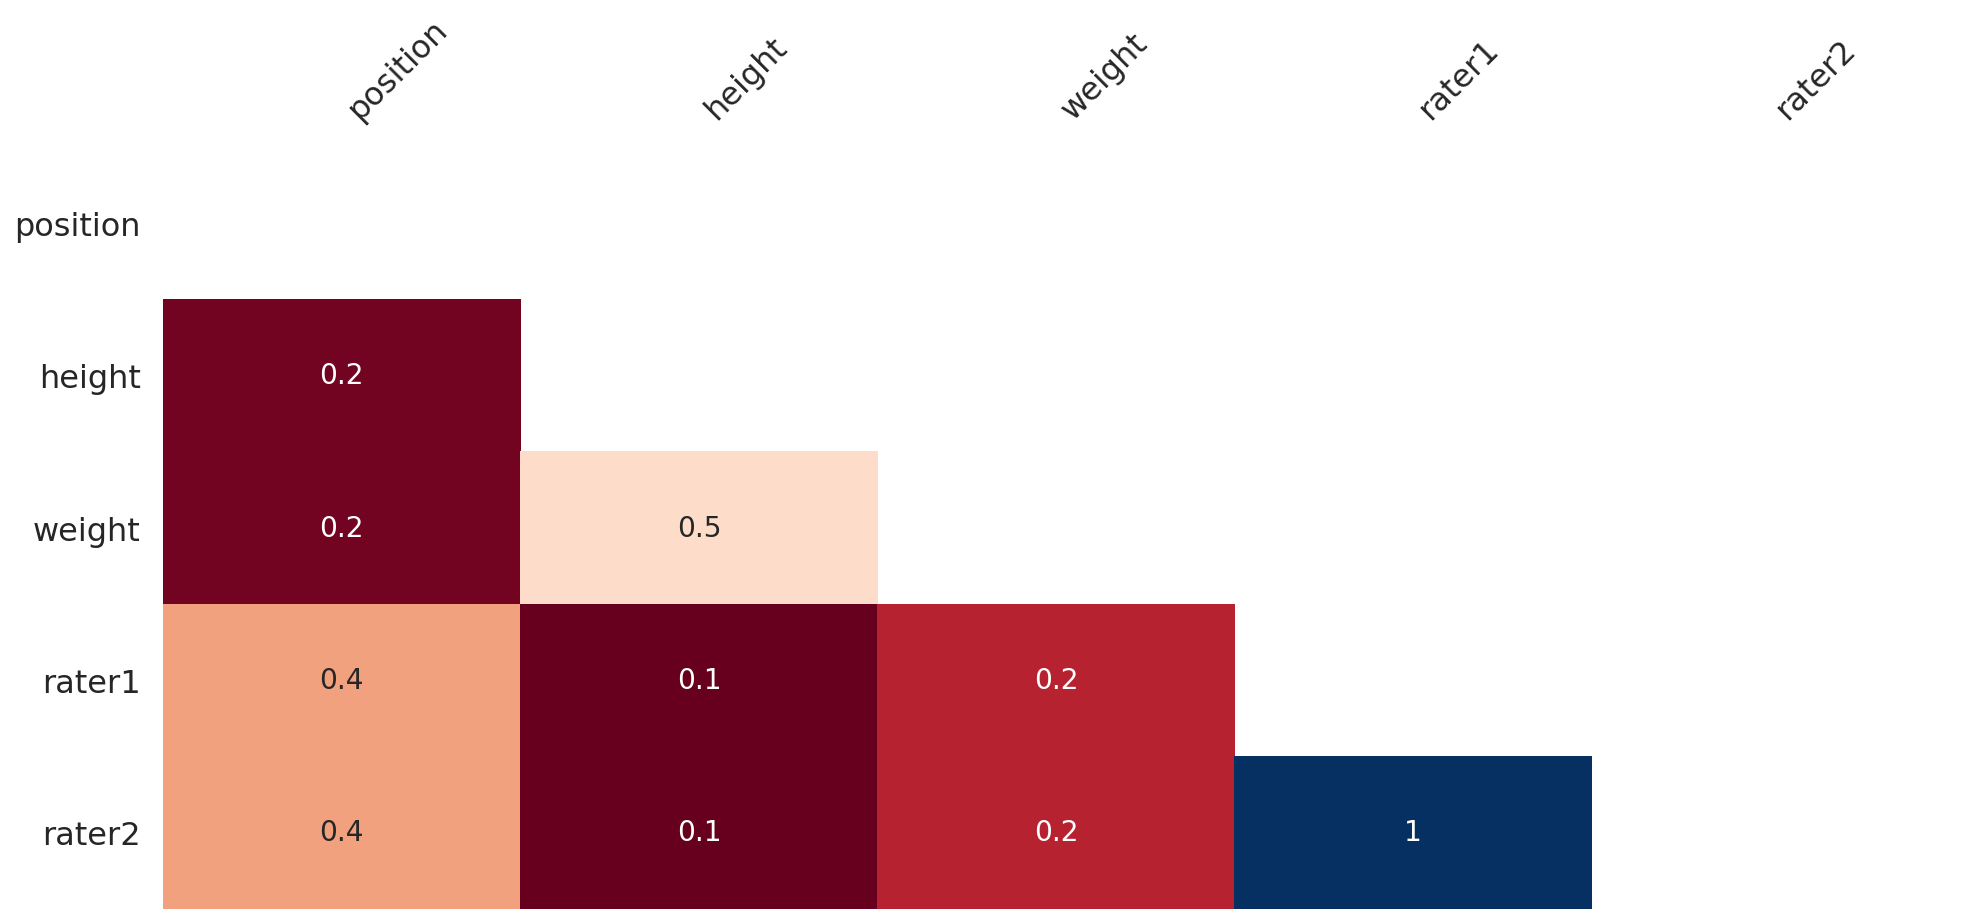

In [7]:
msno.heatmap(players, figsize = (16, 7))

In [8]:
players['rater1'].isnull().sum()

468

In [9]:
players['rater2'].isnull().sum()

468

In [10]:
drop_list = players[players['rater1'].isnull()].index.tolist()

> So for all the 468 players, both rater1 and rater2 hasn't given any rating. Since our task is to check relation between skin colour and red cards, entries with no skin colour are useless to us.. atleast now.

In [11]:
players.drop(drop_list, inplace = True)

In [12]:
players.describe()

,height,weight,rater1,rater2
count,1582.000000,1564.000000,1585.000000,1585.00000
mean,182.044248,76.034527,0.268612,0.31041
std,6.742902,7.105553,0.296578,0.29666
min,161.000000,54.000000,0.000000,0.00000
25%,178.000000,71.000000,0.000000,0.00000
50%,182.000000,76.000000,0.250000,0.25000
75%,187.000000,81.000000,0.500000,0.50000
max,203.000000,100.000000,1.000000,1.00000


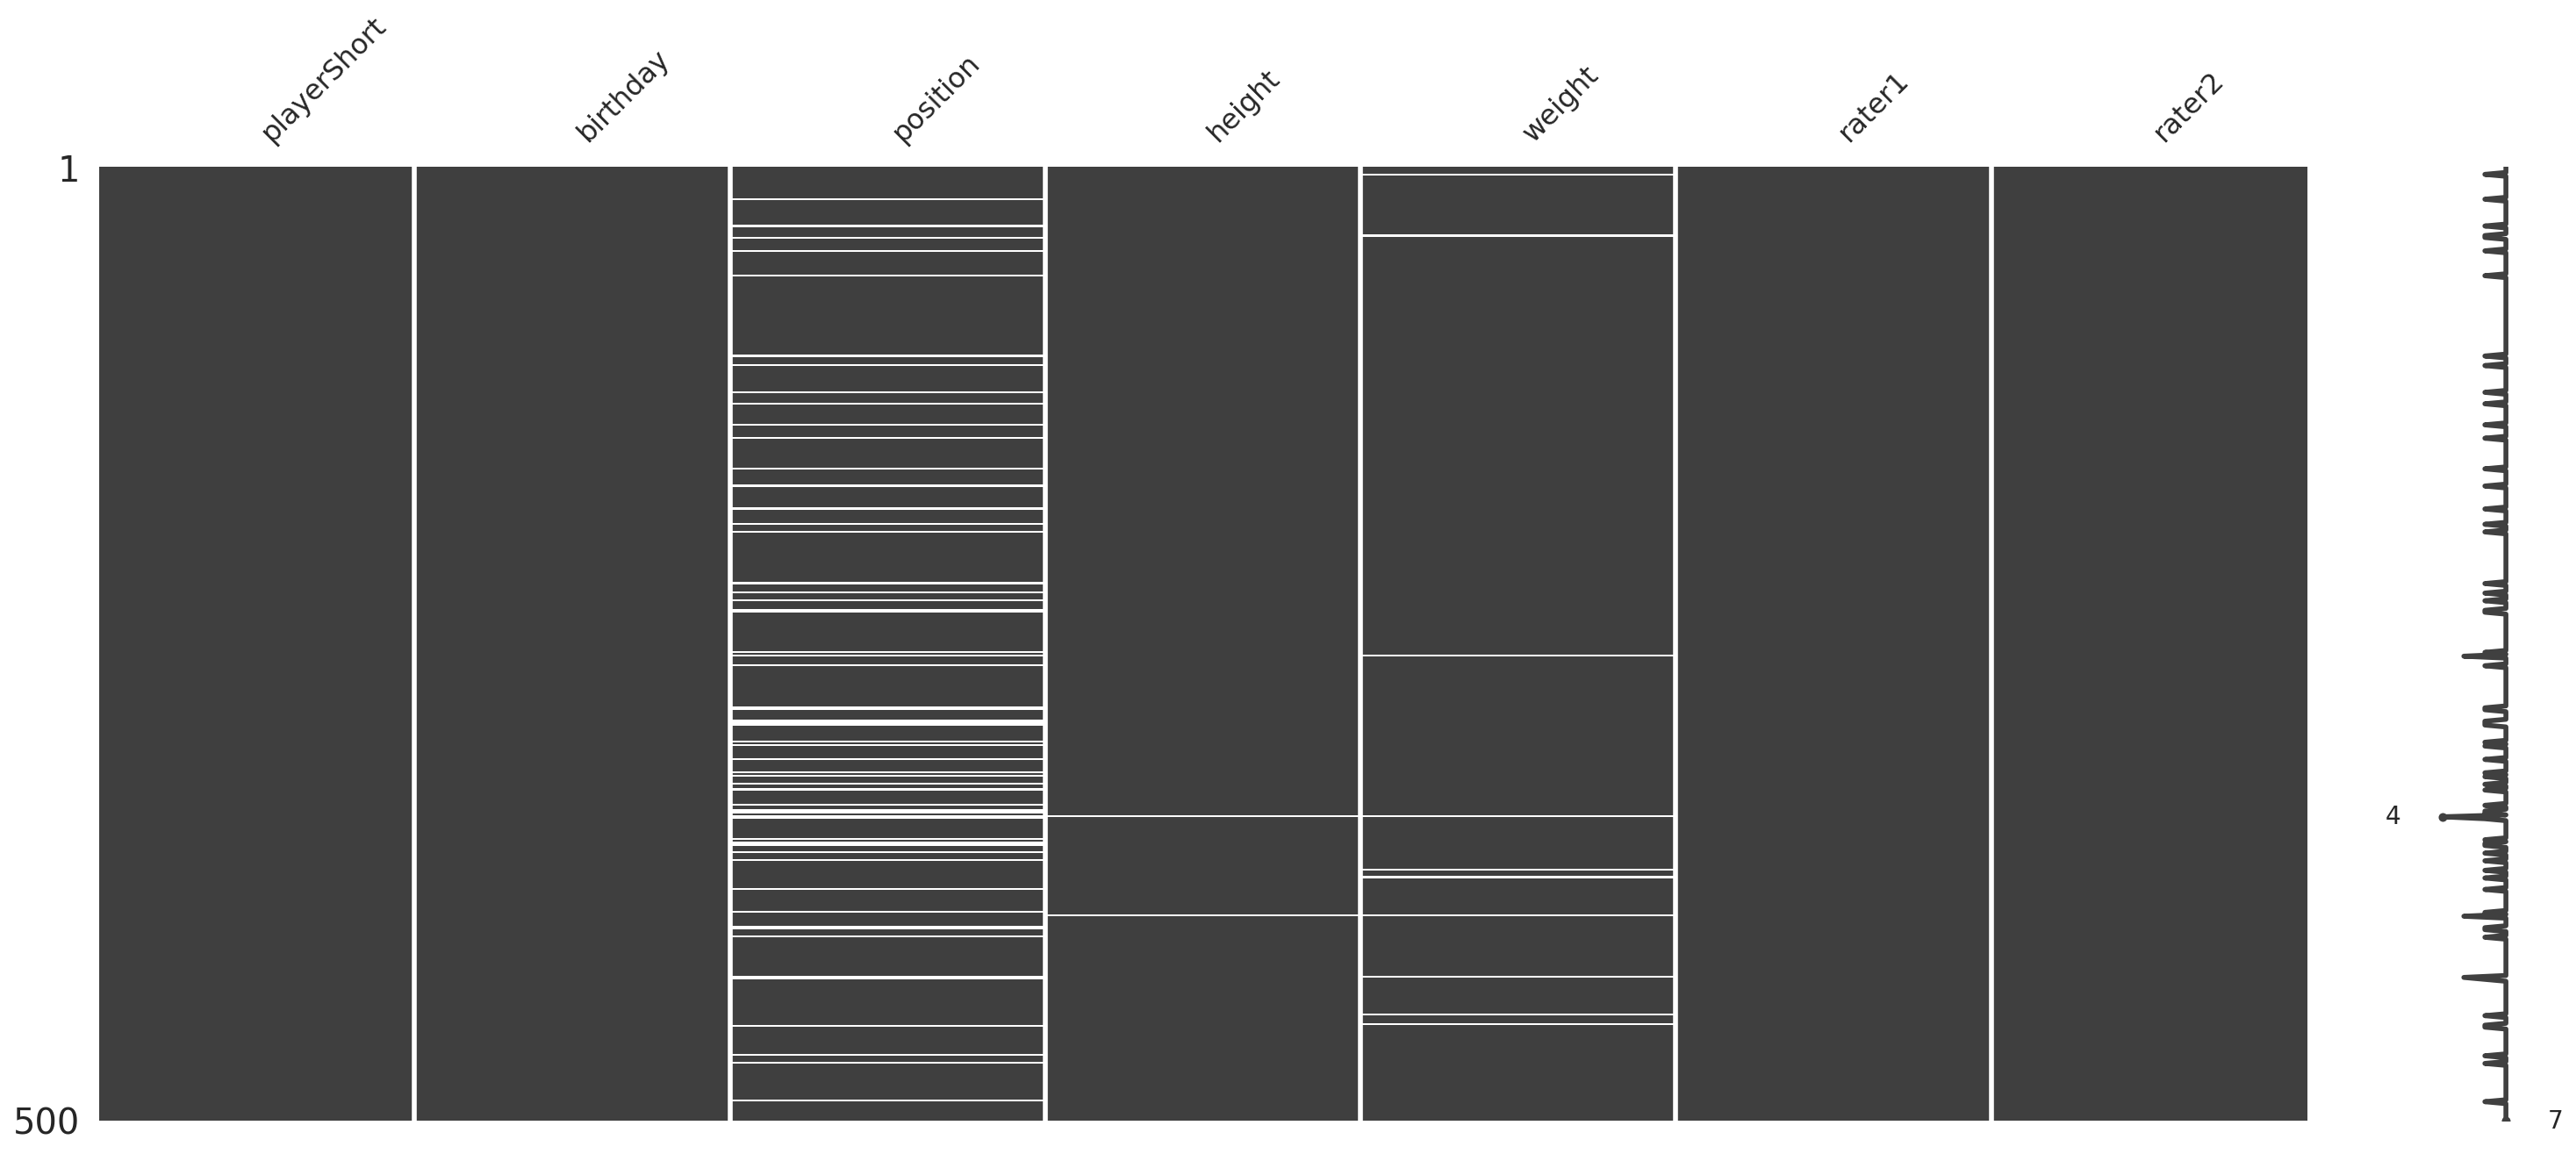

In [13]:
msno.matrix(players.sample(500))

In [14]:
pd.crosstab(players.rater1, players.rater2)

rater2,0.0,0.25,0.5,0.75,1.0
rater1,,,,,
0.00,424,200,2,0,0
0.25,27,470,54,0,0
0.50,0,23,116,31,0
0.75,0,0,2,104,34
1.00,0,0,0,6,92


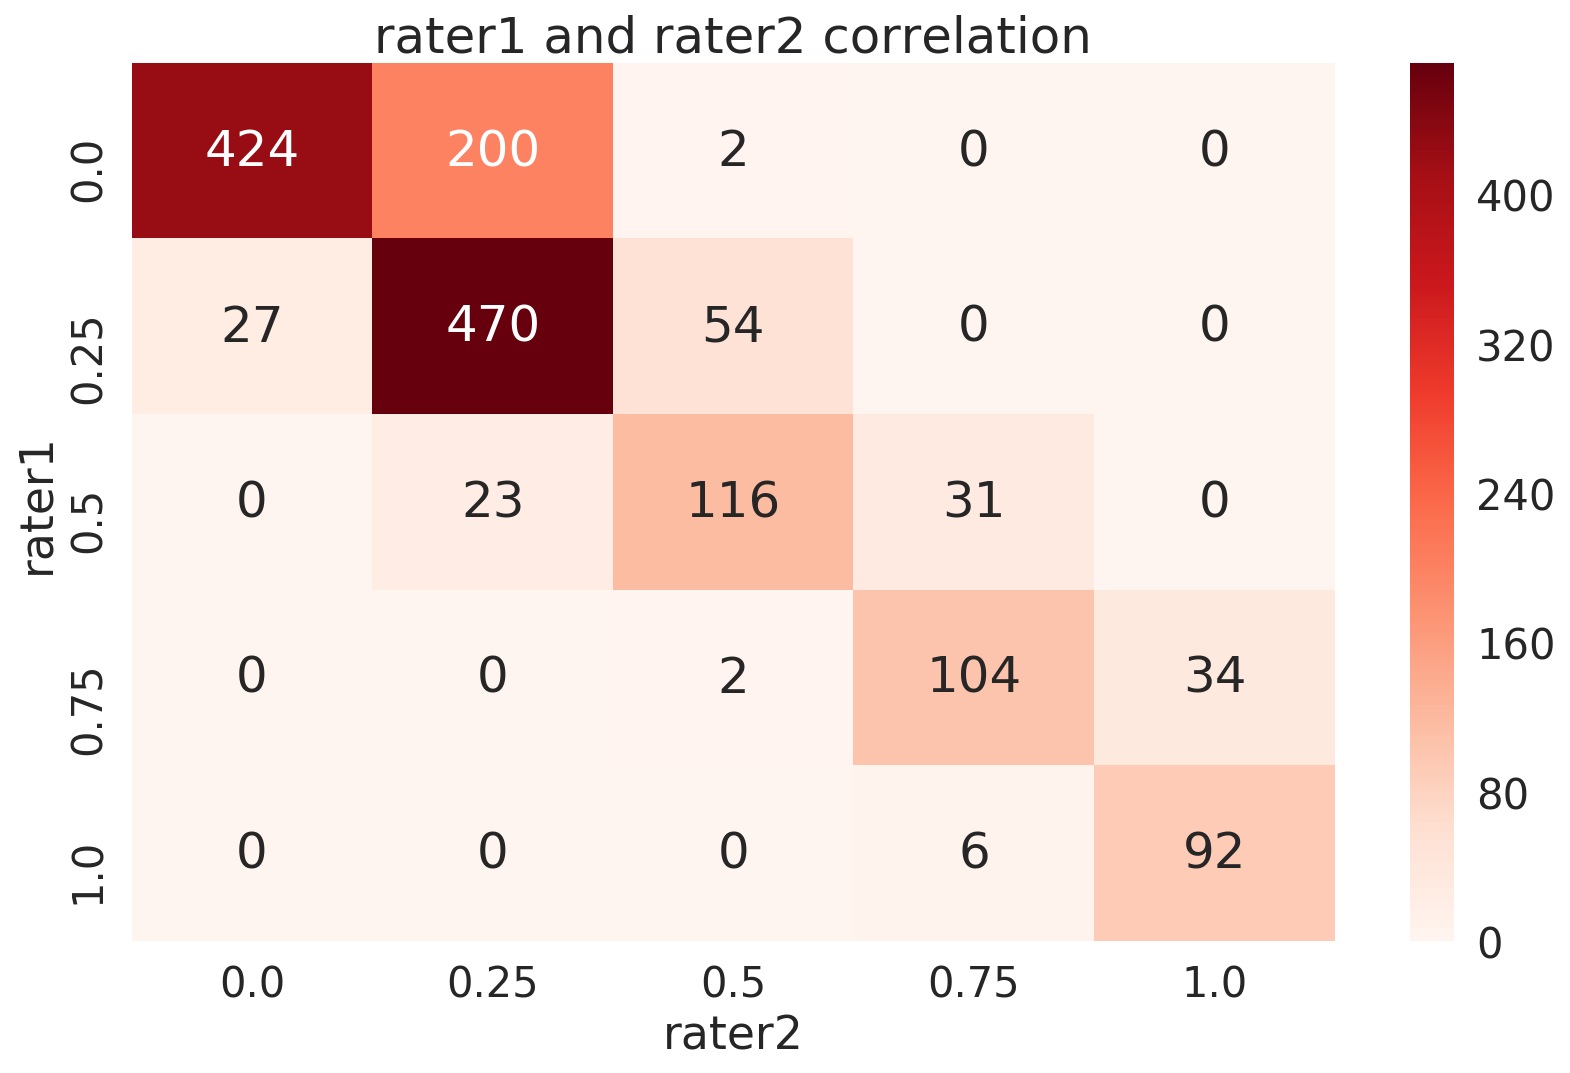

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(pd.crosstab(players.rater1, players.rater2), cmap = 'Reds', annot =True, fmt = 'd', ax = ax ) 
ax.set_title('rater1 and rater2 correlation')
fig.tight_layout()

### Create new useful columns

In [16]:
players.head()

,playerShort,birthday,position,height,weight,rater1,rater2
0,aaron-hughes,08.11.1979,Center Back,182.0,71.0,0.25,0.00
1,aaron-hunt,04.09.1986,Attacking Midfielder,183.0,73.0,0.00,0.25
2,aaron-lennon,16.04.1987,Right Midfielder,165.0,63.0,0.25,0.25
3,aaron-ramsey,26.12.1990,Center Midfielder,178.0,76.0,0.00,0.00
4,abdelhamid-el-kaoutari,17.03.1990,Center Back,180.0,73.0,0.25,0.25


In [17]:
players['skintone'] = players[['rater1','rater2']].mean(axis = 1); players.head()

,playerShort,birthday,position,height,weight,rater1,rater2,skintone
0,aaron-hughes,08.11.1979,Center Back,182.0,71.0,0.25,0.00,0.125
1,aaron-hunt,04.09.1986,Attacking Midfielder,183.0,73.0,0.00,0.25,0.125
2,aaron-lennon,16.04.1987,Right Midfielder,165.0,63.0,0.25,0.25,0.250
3,aaron-ramsey,26.12.1990,Center Midfielder,178.0,76.0,0.00,0.00,0.000
4,abdelhamid-el-kaoutari,17.03.1990,Center Back,180.0,73.0,0.25,0.25,0.250


### Visualizing this univariate feature

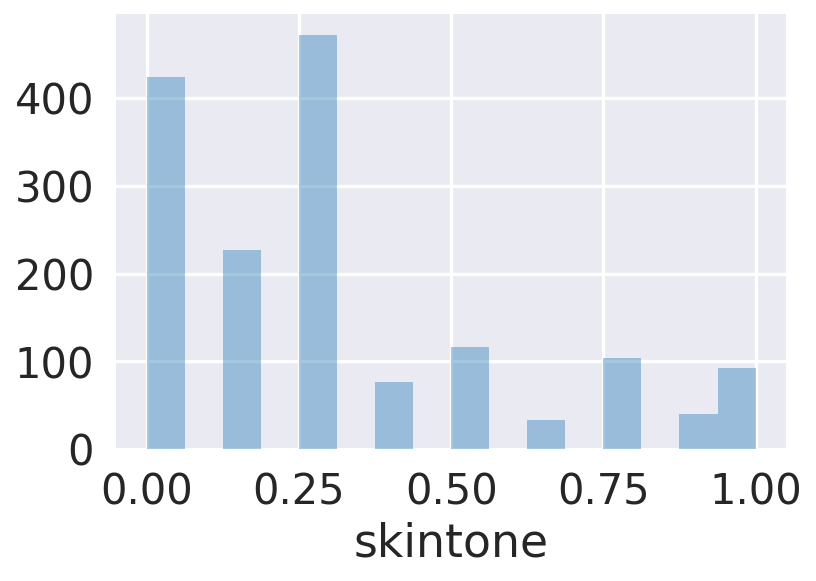

In [18]:
sns.distplot(players['skintone'], kde = False)

### Positions

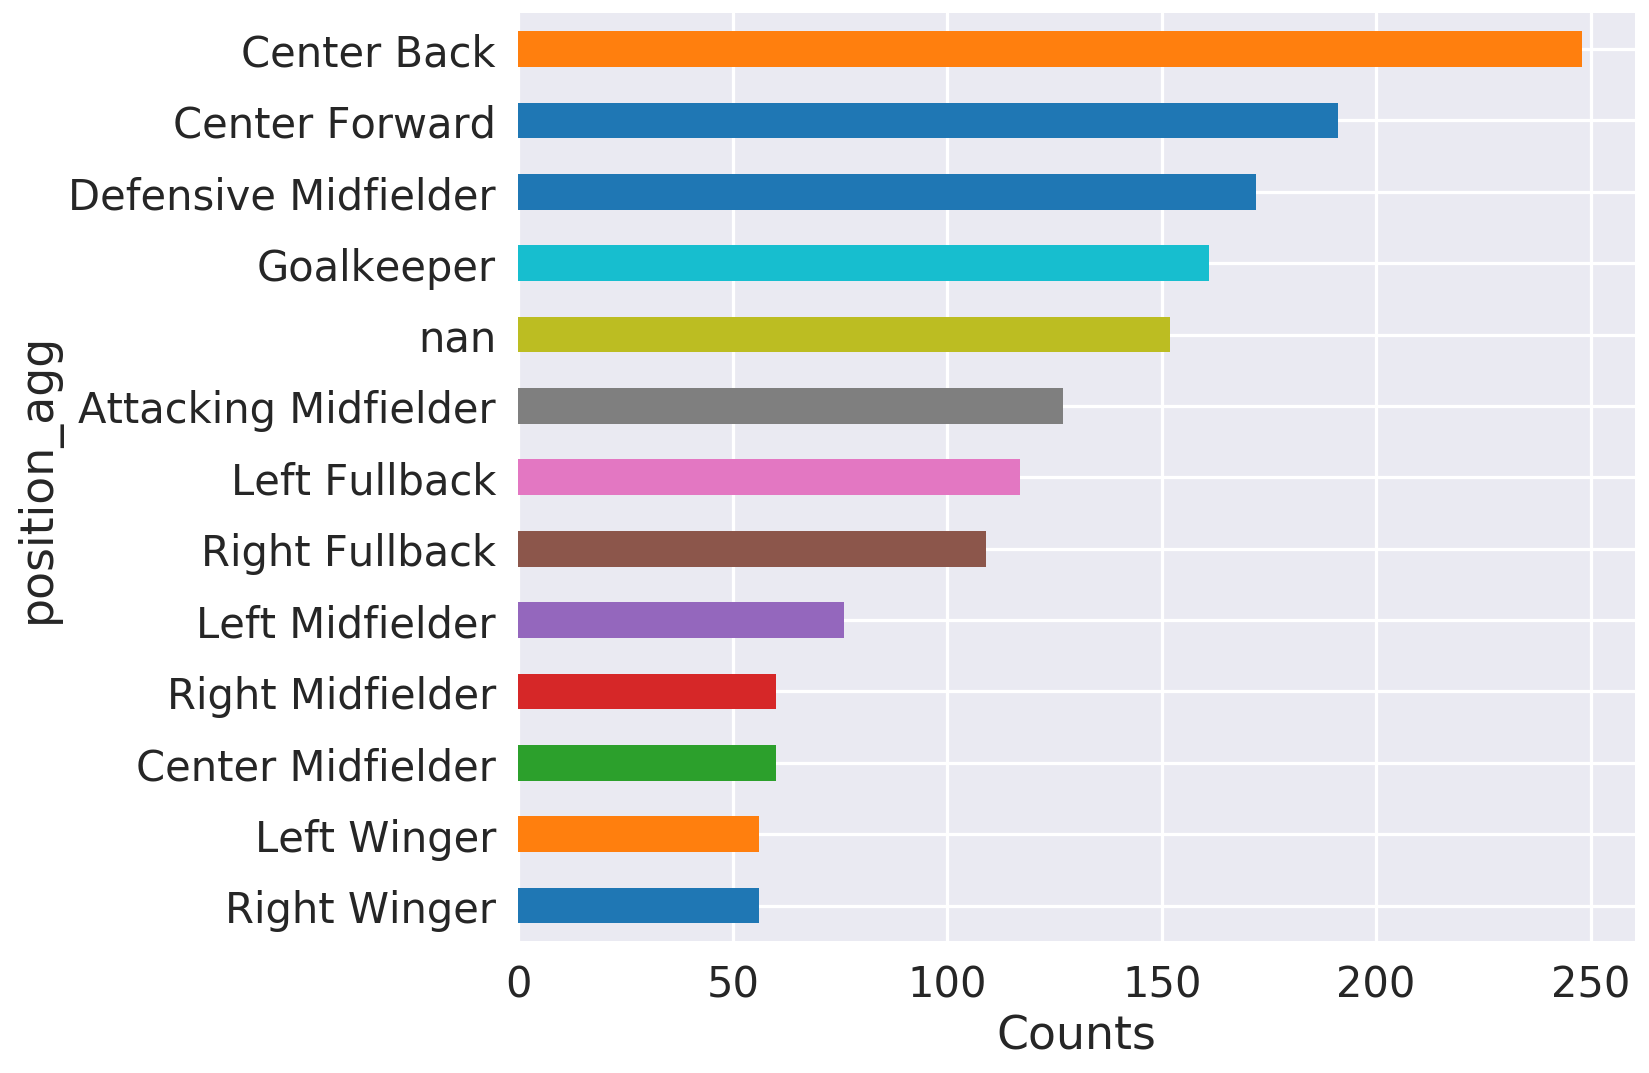

In [19]:
fig, ax = plt.subplots(figsize = (12,8) )
players['position'].value_counts(dropna = False, ascending = True).plot(kind = 'barh', ax = ax)
ax.set_ylabel("position_agg")
ax.set_xlabel("Counts")
fig.tight_layout()

In [20]:
pos_series = players.position.value_counts()

In [21]:
positions = pos_series.index

In [22]:
forward = ['Center Forward', 'Right Winger', 'Left Winger', 'Attacking Midfielder']
defence = ['Center Midfielder','Right Midfielder', 'Left Midfielder', 'Defensive Midfielder']
midfield = ['Center Back', 'Right Fullback', 'Left Fullback']

In [23]:
players.loc[players.position.isin(forward) , 'position_agg'] = 'Forward'
players.loc[players.position.isin(defence), 'position_agg'] = 'Midfield'
players.loc[players.position.isin(midfield) , 'position_agg'] = 'Defensive'
players.loc[players.position == 'Goalkeeper' , 'position_agg'] = 'Keeper'

In [24]:
players.head()

,playerShort,birthday,position,height,weight,rater1,rater2,skintone,position_agg
0,aaron-hughes,08.11.1979,Center Back,182.0,71.0,0.25,0.00,0.125,Defensive
1,aaron-hunt,04.09.1986,Attacking Midfielder,183.0,73.0,0.00,0.25,0.125,Forward
2,aaron-lennon,16.04.1987,Right Midfielder,165.0,63.0,0.25,0.25,0.250,Midfield
3,aaron-ramsey,26.12.1990,Center Midfielder,178.0,76.0,0.00,0.00,0.000,Midfield
4,abdelhamid-el-kaoutari,17.03.1990,Center Back,180.0,73.0,0.25,0.25,0.250,Defensive


### Heights and Weights

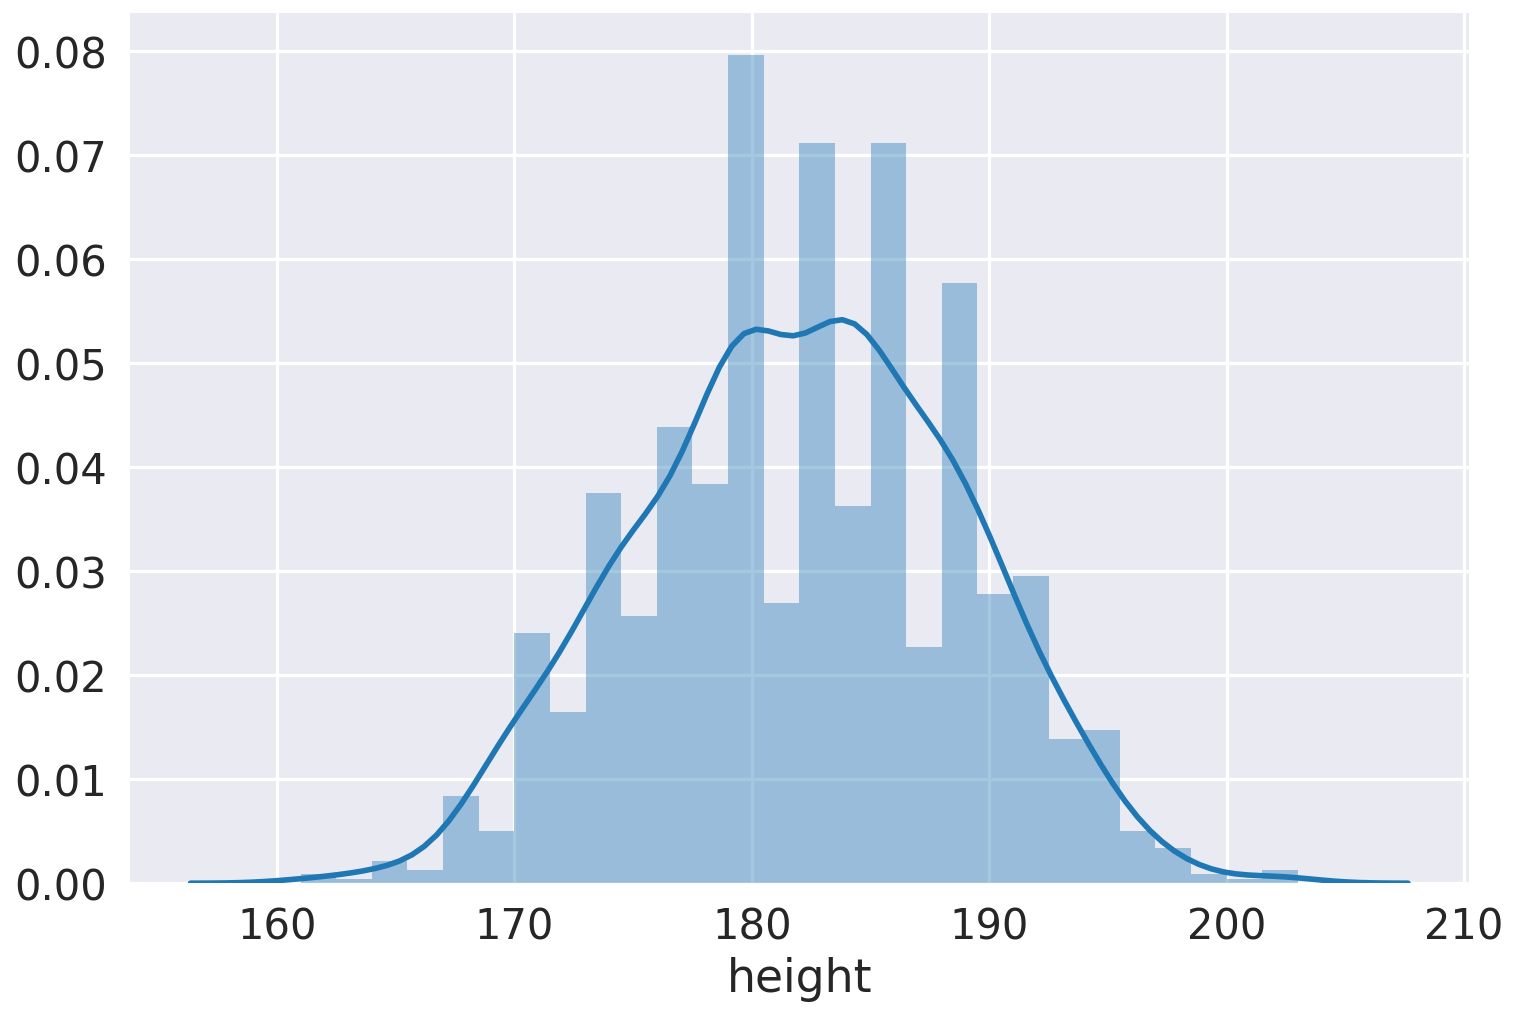

In [25]:
fig, ax = plt.subplots(figsize = (12,8))
sns.distplot(players.height.dropna())

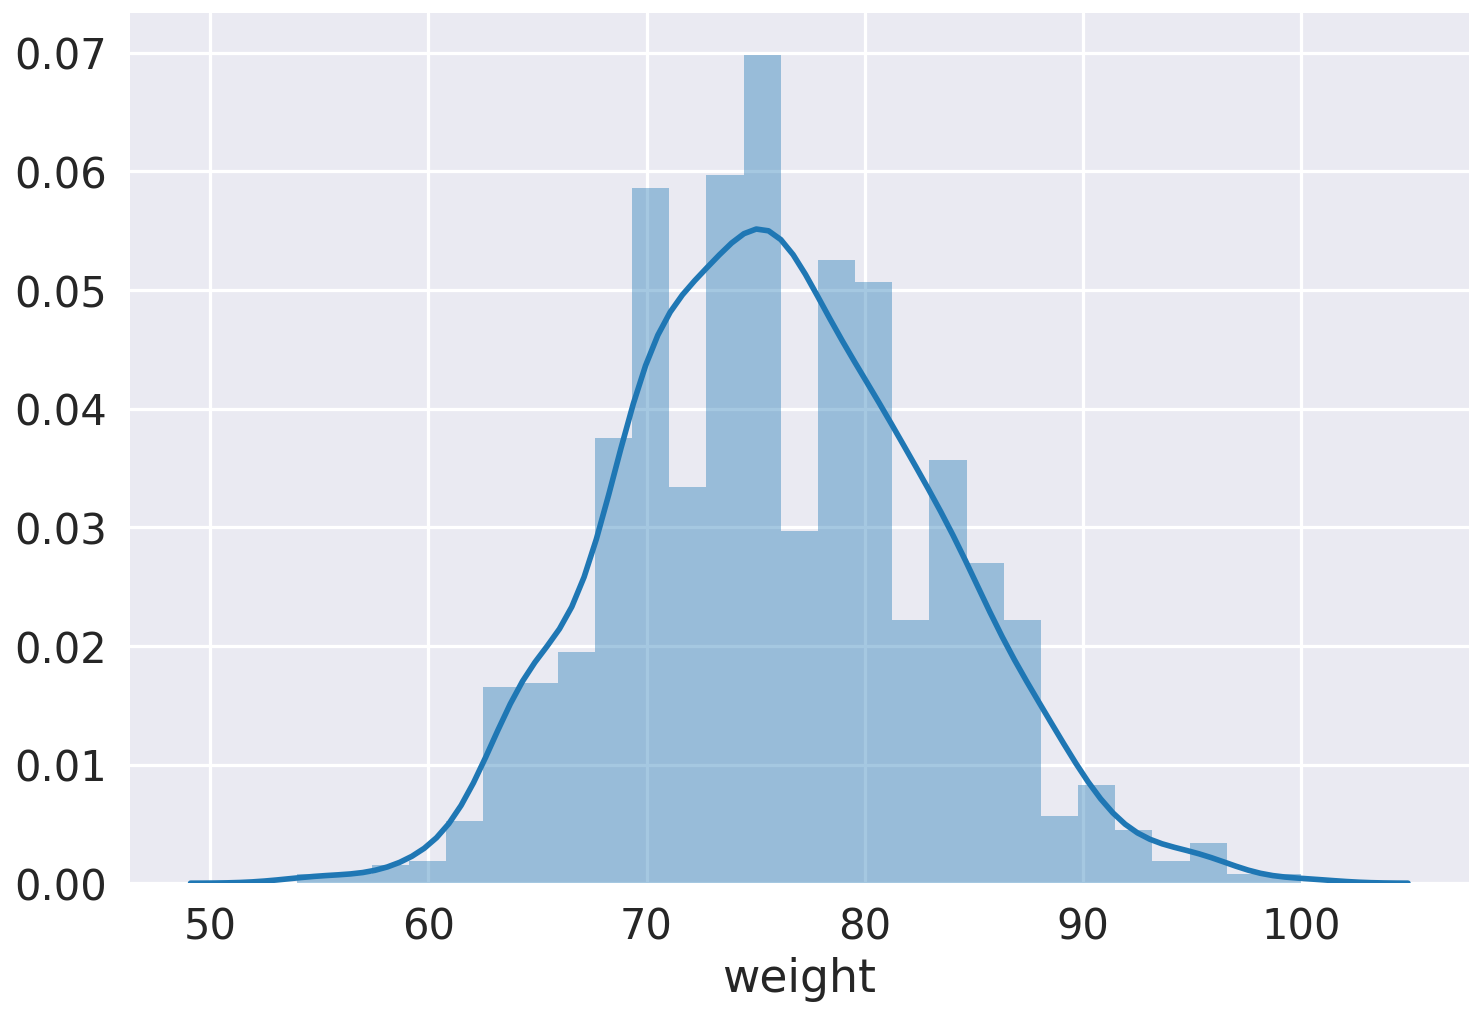

In [26]:
fig, ax = plt.subplots(figsize = (12,8))
sns.distplot(players.weight.dropna())

Text(0.5,0,'weight[kg]')

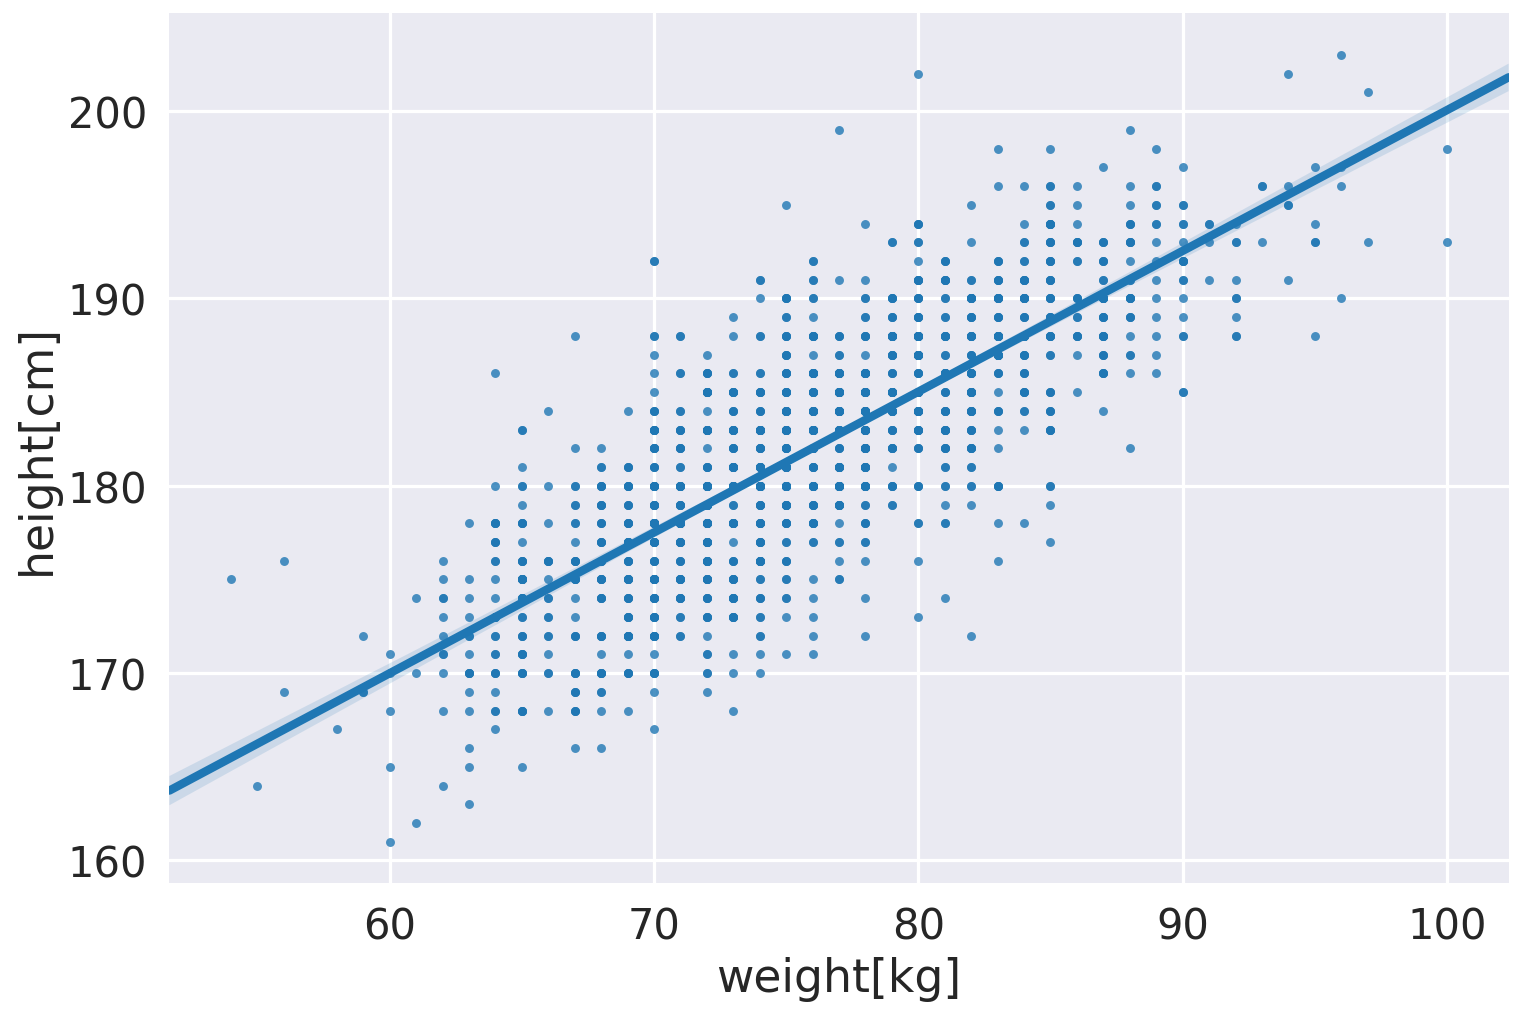

In [27]:
fig, ax = plt.subplots(figsize = (12,8))
sns.regplot('weight', 'height', data = players, ax = ax, scatter_kws = {"s": 20})
ax.set_ylabel('height[cm]')
ax.set_xlabel('weight[kg]')

* There don't seem to be any outliers, i.e. caused by for instance height measured in inches but noted as cm or something

In [28]:
weight_cats = ['vlow_weight', 'low_weight', 'medium_weight', 'high_weight', 'vhigh_weight']

players['weightclass'] = pd.qcut(players.weight, len(weight_cats), weight_cats)

In [29]:
players.head()

,playerShort,birthday,position,height,weight,rater1,rater2,skintone,position_agg,weightclass
0,aaron-hughes,08.11.1979,Center Back,182.0,71.0,0.25,0.00,0.125,Defensive,low_weight
1,aaron-hunt,04.09.1986,Attacking Midfielder,183.0,73.0,0.00,0.25,0.125,Forward,low_weight
2,aaron-lennon,16.04.1987,Right Midfielder,165.0,63.0,0.25,0.25,0.250,Midfield,vlow_weight
3,aaron-ramsey,26.12.1990,Center Midfielder,178.0,76.0,0.00,0.00,0.000,Midfield,medium_weight
4,abdelhamid-el-kaoutari,17.03.1990,Center Back,180.0,73.0,0.25,0.25,0.250,Defensive,low_weight


In [30]:
height_cats = ['vlow_height', 'low_height', 'medium_height', 'high_height', 'vhigh_height']
players['heightclass'] = pd.qcut(players.height, len(height_cats), height_cats)
players.head()

,playerShort,birthday,position,height,weight,rater1,rater2,skintone,position_agg,weightclass,heightclass
0,aaron-hughes,08.11.1979,Center Back,182.0,71.0,0.25,0.00,0.125,Defensive,low_weight,medium_height
1,aaron-hunt,04.09.1986,Attacking Midfielder,183.0,73.0,0.00,0.25,0.125,Forward,low_weight,medium_height
2,aaron-lennon,16.04.1987,Right Midfielder,165.0,63.0,0.25,0.25,0.250,Midfield,vlow_weight,vlow_height
3,aaron-ramsey,26.12.1990,Center Midfielder,178.0,76.0,0.00,0.00,0.000,Midfield,medium_weight,low_height
4,abdelhamid-el-kaoutari,17.03.1990,Center Back,180.0,73.0,0.25,0.25,0.250,Defensive,low_weight,low_height


## Birthday Column

In [31]:
players.birthday.head()

0    08.11.1979
1    04.09.1986
2    16.04.1987
3    26.12.1990
4    17.03.1990
Name: birthday, dtype: object

In [32]:
players['birth_date'] = pd.to_datetime(players.birthday, format='%d.%m.%Y')
players['age_years'] = ((pd.to_datetime("2013-01-01") - players['birth_date']).dt.days)/365.25

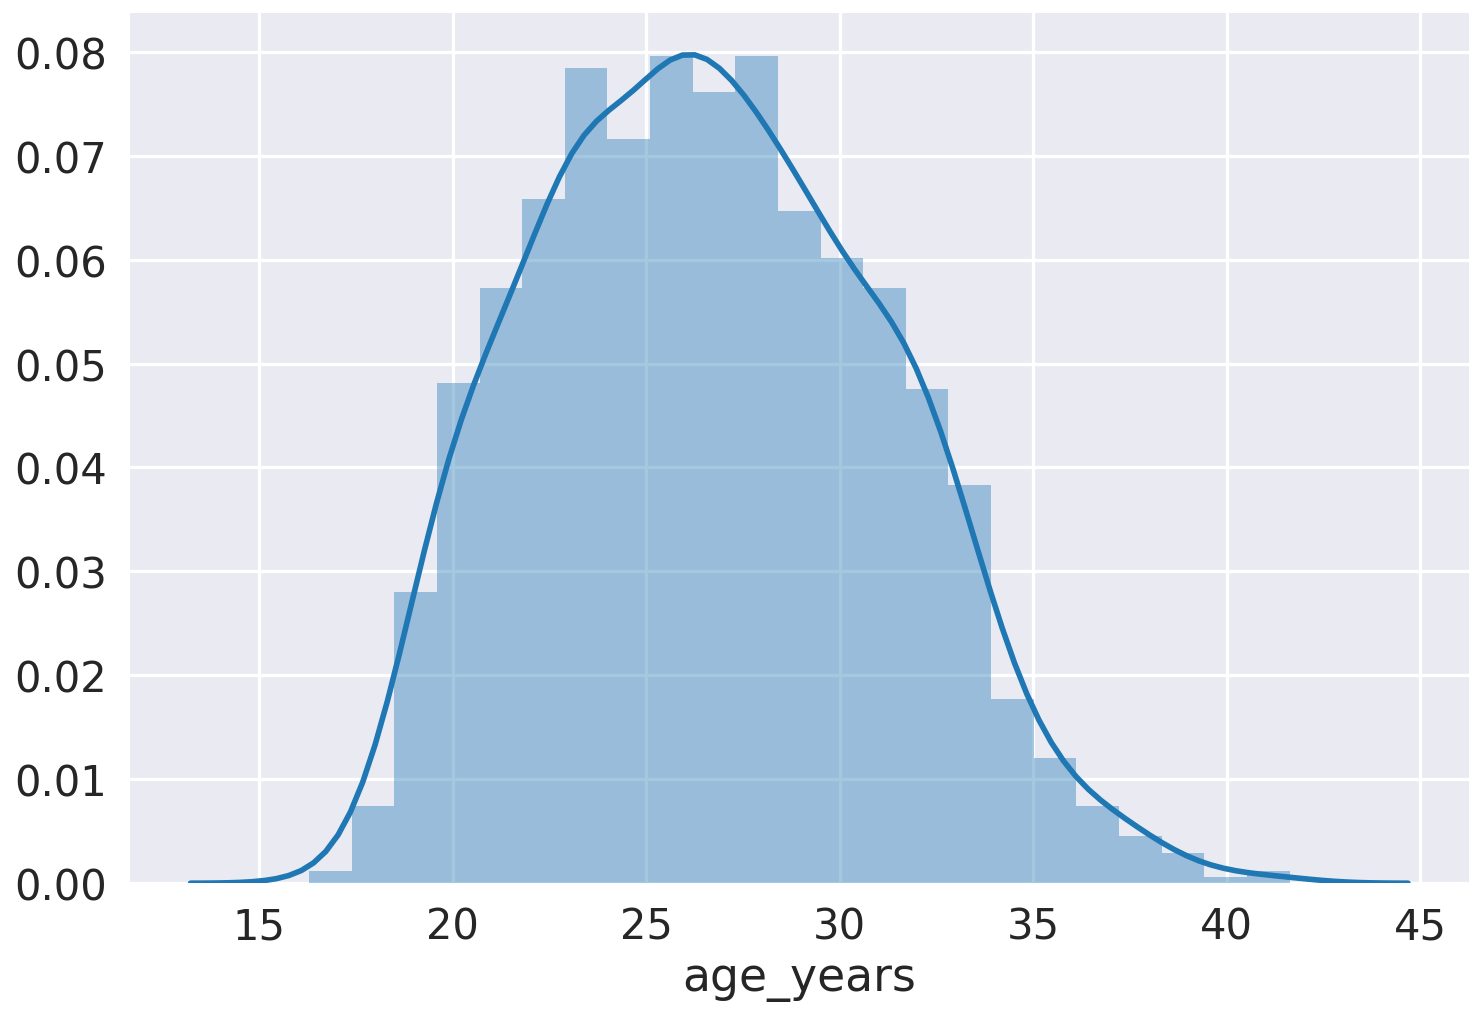

In [33]:
fig, ax = plt.subplots(figsize = (12, 8))
sns.distplot(players.age_years)

In [34]:
players.head()

,playerShort,birthday,position,height,weight,rater1,rater2,skintone,position_agg,weightclass,heightclass,birth_date,age_years
0,aaron-hughes,08.11.1979,Center Back,182.0,71.0,0.25,0.00,0.125,Defensive,low_weight,medium_height,1979-11-08,33.149897
1,aaron-hunt,04.09.1986,Attacking Midfielder,183.0,73.0,0.00,0.25,0.125,Forward,low_weight,medium_height,1986-09-04,26.327173
2,aaron-lennon,16.04.1987,Right Midfielder,165.0,63.0,0.25,0.25,0.250,Midfield,vlow_weight,vlow_height,1987-04-16,25.713895
3,aaron-ramsey,26.12.1990,Center Midfielder,178.0,76.0,0.00,0.00,0.000,Midfield,medium_weight,low_height,1990-12-26,22.017796
4,abdelhamid-el-kaoutari,17.03.1990,Center Back,180.0,73.0,0.25,0.25,0.250,Defensive,low_weight,low_height,1990-03-17,22.795346


In [35]:
players.drop(columns = ['birthday', 'birth_date'], axis = 1, inplace = True); players.head()

,playerShort,position,height,weight,rater1,rater2,skintone,position_agg,weightclass,heightclass,age_years
0,aaron-hughes,Center Back,182.0,71.0,0.25,0.00,0.125,Defensive,low_weight,medium_height,33.149897
1,aaron-hunt,Attacking Midfielder,183.0,73.0,0.00,0.25,0.125,Forward,low_weight,medium_height,26.327173
2,aaron-lennon,Right Midfielder,165.0,63.0,0.25,0.25,0.250,Midfield,vlow_weight,vlow_height,25.713895
3,aaron-ramsey,Center Midfielder,178.0,76.0,0.00,0.00,0.000,Midfield,medium_weight,low_height,22.017796
4,abdelhamid-el-kaoutari,Center Back,180.0,73.0,0.25,0.25,0.250,Defensive,low_weight,low_height,22.795346


## This is a fairly comprehensive table that gives a fair amount of choice of variables to use and/or drop. Onto the next

In [36]:
players.to_csv('tidy_players.csv.gz', compression = 'gzip', encoding = 'UTF8')

In [37]:
players.head()

,playerShort,position,height,weight,rater1,rater2,skintone,position_agg,weightclass,heightclass,age_years
0,aaron-hughes,Center Back,182.0,71.0,0.25,0.00,0.125,Defensive,low_weight,medium_height,33.149897
1,aaron-hunt,Attacking Midfielder,183.0,73.0,0.00,0.25,0.125,Forward,low_weight,medium_height,26.327173
2,aaron-lennon,Right Midfielder,165.0,63.0,0.25,0.25,0.250,Midfield,vlow_weight,vlow_height,25.713895
3,aaron-ramsey,Center Midfielder,178.0,76.0,0.00,0.00,0.000,Midfield,medium_weight,low_height,22.017796
4,abdelhamid-el-kaoutari,Center Back,180.0,73.0,0.25,0.25,0.250,Defensive,low_weight,low_height,22.795346
